In [53]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector 
from qiskit_algorithms.optimizers import ADAM, COBYLA, SPSA

In [54]:
def create_ansatz(num_qubits, num_layers, ansatz_type='g2'):
    qc = QuantumCircuit(num_qubits)
                    
    params_per_layer = 0
    if ansatz_type == 'g2':
        params_per_layer = 2*num_qubits
    elif ansatz_type == 'g2_gN':
        params_per_layer = 3*num_qubits
    elif ansatz_type == 'g2_gN_W':
        params_per_layer = 6*num_qubits
    else:
        raise ValueError("Unknown ansatz type.")
    
    total_params = params_per_layer*num_layers
    theta = ParameterVector('theta', total_params)
    param_idx = 0

    for l in range(num_layers):
        # |g2>
        for i in range(num_qubits):
            qc.ry(theta[param_idx], i)
            param_idx += 1
            
        for i in range(0, num_qubits-1, 2):
            qc.cz(i, i+1)

        for i in range(num_qubits):
            qc.ry(theta[param_idx], i)
            param_idx += 1

        for i in range(1, num_qubits-1, 2):
            qc.cz(i, i+1)
        qc.cz(num_qubits-1, 0)

        if ansatz_type == 'g2':
            qc.barrier()
            continue

        # |g2>+|gN>
        for i in range(num_qubits):
            qc.ry(theta[param_idx], i)
            param_idx += 1
            
        if num_qubits > 1:
            qc.mcp(np.pi, list(range(num_qubits-1)), num_qubits-1)

        if ansatz_type == 'g2_gN':
            qc.barrier()
            continue

        # |g2>+|gN>+W
        for i in range(num_qubits):
            qc.rz(theta[param_idx], i)
            param_idx += 1

        for i in range(num_qubits):
            qc.rx(theta[param_idx], i)
            param_idx += 1

        for i in range(num_qubits):
            qc.rz(theta[param_idx], i)
            param_idx += 1
        if ansatz_type == 'g2_gN_W':
            qc.barrier()
            continue
        
    return qc

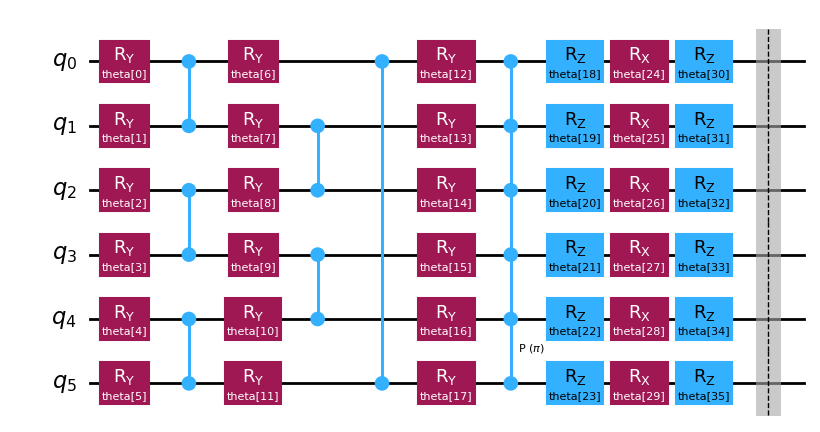

In [55]:
num_qubits = 6
num_layers = 1

ansatz = create_ansatz(num_qubits, num_layers, ansatz_type = 'g2_gN_W')

ansatz.draw('mpl')

In [56]:
def cost_function_fast(params, ansatz, v_dagger, cost_history, N):
    bound_ansatz = ansatz.assign_parameters(params)
    state = Statevector.from_instruction(bound_ansatz)

    state = state.evolve(v_dagger)
    
    p0 = np.abs(state.data[0])**2
    
    cost = np.sqrt(max(0, 1 - p0)) 
    cost_history.append(cost)
    return cost

In [57]:
def v_dagger():
    
    v = QuantumCircuit(3)
    v.h(0)
    v.cx(0, 1)
    v.cx(1, 2)
    

    ''''
    v = QuantumCircuit(3)
    theta = 2*np.arccos(1/np.sqrt(3))

    v.ry(theta, 0)   
    v.ch(0, 1)       
    v.cx(1, 2)       
    v.cx(0, 1)       
    v.x(0)           
    '''

    '''
    v_raw = QuantumCircuit(3)
    ame_vector = np.zeros(8, dtype=complex)

    ame_vector[0] = 0.27                       
    ame_vector[1] = 0.363                       
    ame_vector[2] = 0.326                       
    ame_vector[4] = 0.377                       
    ame_vector[7] = 0.74*np.exp(-0.79j*np.pi) 

    norm = np.linalg.norm(ame_vector)
    ame_vector = ame_vector/norm

    v_raw.prepare_state(ame_vector, [0, 1, 2])
    v = transpile(v_raw, basis_gates=['u', 'cx'], optimization_level=1)
    '''

    print(Statevector.from_instruction(v))
    return v.inverse()

In [58]:
N = 3
num_layers = 2
max_iter = 200
ansatz_type = 'g2_gN_W'

v_dagger = v_dagger()

ansatz = create_ansatz(N, num_layers, ansatz_type)
initial_params = np.random.uniform(0, 2*np.pi, ansatz.num_parameters)
cost_history = []

optimizer = ADAM(maxiter = max_iter, lr = 0.05)

result = optimizer.minimize(
    fun=lambda p: cost_function_fast(p, ansatz, v_dagger, cost_history, N),
    x0=initial_params
)

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.70710678+0.j],
            dims=(2, 2, 2))


最终 Cost: 0.01757656501513498


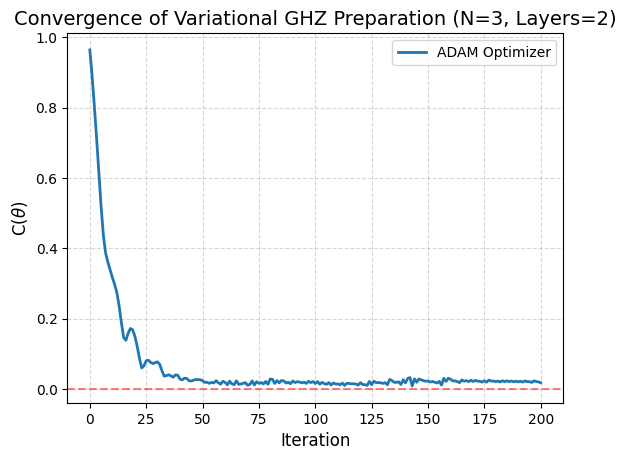

In [59]:
stride = ansatz.num_parameters+1
filtered_cost_history = cost_history[::stride]

print(f"最终 Cost: {result.fun}") 

plt.figure()
plt.plot(filtered_cost_history, label='ADAM Optimizer', linewidth=2)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5) # 参考线
plt.title(f"Convergence of Variational GHZ Preparation (N={N}, Layers={num_layers})", fontsize=14)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel(r"C($\theta$)", fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.show()